In [90]:
# Standard library imports
import re
import json
import sys
# print(sys.path)
import os
print(os.getcwd())

# Now import utils
from project_utils import load_and_prepare_data, print_html, get_response, get_feedback

/Users/betty/Documents/Work/AgenticAI/AgenticAI


ImportError: cannot import name 'get_feedback' from 'project_utils' (/Users/betty/Documents/Work/AgenticAI/AgenticAI/project_utils.py)

In [24]:
# Use this utils.py function to load the data into a dataframe
df = load_and_prepare_data('coffee_sales.csv')

# Grab a random sample to display
print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-03-16,08:30,card,ANON-0000-0000-0061,3.380,Americano with Milk,1,3,2024
2024-08-23,13:47,card,ANON-0000-0000-0539,2.302,Americano,3,8,2024
2024-10-28,14:05,card,ANON-0000-0000-0257,3.576,Cappuccino,4,10,2024
2025-03-11,10:39,card,ANON-0000-0000-1276,3.576,Hot Chocolate,1,3,2025
2025-01-09,17:53,card,ANON-0000-0000-0329,3.576,Latte,1,1,2025


In [25]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with plotly.expredd using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (%Y-%m-%d)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    The code should generate the following fields from the date column
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use plotly.express for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' .
    5. Do not call fig.show().
    6. Close all plots with fig.close().
    7. Add all necessary import python statements
    8. check the complete code for any brackets that have not been closed.

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = get_response(model=model, prompt=prompt)
    return response

In [26]:
# Generate initial code
code_v1 = generate_chart_code(
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.",  
    model="llama3",
    out_path_v1="chart_v1.png"
)

print_html(code_v1, title="LLM output with first draft code")

[project_utils] get_response model='llama3'


In [27]:
# import plotly.io as pio
# from plotly.io.kaleido import kaleido_available
# print("kaleido_available:", kaleido_available())
import pandas as pd
import plotly.express as px
import numpy as np

df = pd.read_csv('coffee_sales.csv')

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month

fig = px.bar(x='quarter', y='price',
             color='cash_type', category_orders={'cash_type': ['card', 'cash']},
             data_frame=df[(df['year'] == 2024) | (df['year'] == 2025)],
             hover_name='coffee_name')

fig.update_layout(title_text='Q1 Coffee Sales - 2024 vs. 2025',
                   xaxis_title_text='Quarter',

                   yaxis_title_text='Price')
# fig.write_image('chart_v1.png', scale=2)
fig.show()

In [28]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df, "px": px}
    exec(initial_code, exec_globals)
    # exec(initial_code)

# If code run successfully, the file chart_v1.png should have been generated
print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

ValueError: Cannot accept list of column references or list of columns for both `x` and `y`.

In [30]:
import ollama
import base64

with open("chart_v1.png", "rb") as f:
    b64_img = base64.b64encode(f.read()).decode("utf-8")

response = ollama.chat(
    model="llava",
    messages=[
        {
            "role": "user",
            "content": "You are a data visualization expert. Have a look at the chart which is displaying coffee sales in 2024 and 2025. Can you think of improvements to this chart, so an executive could make better decisions based on what is shown. How would the a better chart look like. Would it be a line chart or scatter plot or boxplot etc. and what would be on the x and y axis? Please provide a short description of the improved chart.",
            "images": [b64_img],  # <- Ollama uses a separate key for images
        }
    ]
)

print(response["message"]["content"])


 As a data visualization expert, I can suggest several improvements to this bar chart to help an executive make better decisions based on the data presented:

1. **Title and Axis Labels**: The title "Coffee sales" is clear, but it could be more descriptive. Adding a subtitle that explains what the bars represent (e.g., "Total revenue in Q1 2024 vs. Q1 2025") would be helpful for quick comprehension. Additionally, ensure that both axes have appropriate labels and units, so the reader knows exactly what they are looking at.

2. **Data Visualization Technique**: A clustered bar chart with two sets of bars is effective for comparing quantities across different categories. However, to better show changes over time, a line chart or a combination line-bar chart could be used. This would allow the viewer to see trends and growth more clearly.

3. **Color Coding**: Introducing color coding or shading could help to distinguish between different data points, such as Q1 2024 vs. Q1 2025, or to hig

In [31]:
new_instructions = response["message"]["content"]

In [ ]:
prompt = f"""
You are a data scientists and have generated the following python code: {code_v1} to plot coffee sales. 
However a visualisation specalist has taken a look at the graph you have generated and made the following suggestions for improvements: {new_instructions}.
Generate new python code to plot the graph.

Return your answer *strictly* in this format:

<execute_python>
# valid python code here
</execute_python>

Do not add explanations, only the tags and the code.

The code should create a visualization from a DataFrame 'df' which has these columns:
- date (%Y-%m-%d)
- time (HH:MM)
- cash_type (card or cash)
- card (string)
- price (number)
- coffee_name (string)
The following fields need to be generated from the date column
- quarter (1-4)
- month (1-12)
- year (YYYY) 
"""
model = "llama3"

new_response = get_response(model=model, prompt=prompt)

[project_utils] get_response model='llama3'


In [38]:
print_html(new_response, title="LLM output with feedback")

In [43]:
import pandas as pd
from plotly import graph_objects as go
import plotly.express as px

# Calculate quarter, month and year from date column
df['quarter'] = df['date'].dt.to_period('Q')
df['month'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.to_period('Y')

# Filter Q1 data for 2024 and 2025
q1_2024 = df[(df['quarter'] == 1) & (df['year'] == 2024)]
q1_2025 = df[(df['quarter'] == 1) & (df['year'] == 2025)]

fig = go.Figure(data=[go.Scatter(x=q1_2024.groupby(['year']).mean()['price'], 
                                 y=q1_2024.groupby(['year']).count()['coffee_name'],
                                 mode='lines+markers', stackgroup='general'),
                      go.Bar(x=q1_2024.groupby(['year']).mean()['price'], 
                             y=q1_2024.groupby(['year']).count()['coffee_name'],
                             name='Q1 2024',
                             marker_color='blue'
                            ),
                      go.Bar(x=q1_2025.groupby(['year']).mean()['price'], 
                             y=q1_2025.groupby(['year']).count()['coffee_name'],
                             name='Q1 2025',
                             marker_color='red'
                            )])

fig.update_layout(title='Q1 Coffee Sales in 2024 and 2025', title_font_size=16,
                  xaxis_title='Year', yaxis_title='Number of Purchases', barmode='group')

q1_2025_avg = q1_2025.groupby(['year']).mean()['price']
# fig.add_shape(type="rect",
#               x0=None, y0=None, x1=None, y1=None,
#               fillcolor=q1_2025_avg.mean(), opacity=0.25)

# fig.write_image('chart_v2.png')
fig.show()

In [44]:
df.head()

,date,time,cash_type,card,price,coffee_name,year,quarter,month
0,2024-03-01,06:14,card,ANON-0000-0000-0001,3.87,Latte,2024,2024Q1,2024-03
1,2024-03-01,11:10,card,ANON-0000-0000-0002,3.87,Hot Chocolate,2024,2024Q1,2024-03
2,2024-03-01,11:19,card,ANON-0000-0000-0002,3.87,Hot Chocolate,2024,2024Q1,2024-03
3,2024-03-01,11:37,card,ANON-0000-0000-0003,2.89,Americano,2024,2024Q1,2024-03
4,2024-03-01,12:56,card,ANON-0000-0000-0004,3.87,Latte,2024,2024Q1,2024-03


In [54]:
quarter_df = df.groupby(['date', 'coffee_name']).agg({'price': 'mean'}).reset_index()
quarter_df.head()
fig = px.scatter(x='date', y='price', color='coffee_name', data_frame=quarter_df)

fig.show()

In [59]:
df.groupby(['coffee_name','year']).agg({'price':'mean', 'time':'count'}).reset_index()
df.date.max()

Timestamp('2025-03-23 00:00:00')

## Evaluate LLM calls with reflection

In [78]:
prompt_data_analysis = open("prompt_data.txt").read()

In [79]:
print(prompt_data_analysis)

"Look at the dataframe df of coffee sales. Run some simple analysis. How many coffee names have been sold per month. which ones sell best. 
what is the average price per coffee and month. what date range are we looking at and what is the best time for coffee sell. 
To see what sort of analysis is possible look at the dataframe first. Load necessary packages. for plots use matplotlib.

check the names of the columns before you start anal;ysis the file to be loaded is names coffee_sales.csv

return the python code in between <python>"


In [83]:
model = "llama3"

response_data1 = get_response(model=model, prompt=prompt_data_analysis)

response_data1

[project_utils] get_response model='llama3'


'Here\'s a simple Python program that will run an analysis on the coffee sales data:\n\n```Python\n<python>\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport datetime as dt\n\n# Load the dataset\ndf = pd.read_csv(\'coffee_sales.csv\')\n\n# Convert the \'Date\' column to datetime format for easier analysis\ndf[\'Date\'] = pd.to_datetime(df[\'Date\'])\n\n# Set the date range we are interested in, say January 2022 and onward\nstart_date = \'2022-01-01\'\nend_date = df[\'Date\'].max()\n\n# Filter the dataframe to only include dates within our desired range\ndf = df[(df[\'Date\'] > start_date) & (df[\'Date\'] < end_date)]\n\n# Reshape the \'Date\' column to be a datetime object\ndf[\'Date\'] = pd.to_datetime(df[\'Date\'])\n\n# Reset the index of your dataframe for easier analysis\ndf.reset_index(drop=True, inplace=True)\n\n# View the first few rows of our dataset\nprint(df.head())\n\n# Let\'s calculate some overall statistics\nprint("Number of unique coffee names:", df[\'Coffee 

In [ ]:
print_html(response_data1, title="LLM output version 1")

In [97]:
match = re.search(r"<python>([\s\S]*?)</python>", response_data1)
if match:
    initial_code = match.group(1).strip()
    print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df, "px": px}
    exec(initial_code, exec_globals)
    # exec(initial_code)




KeyError: 'Date'

In [98]:
response_data2 = get_feedback(model=model, original_prompt=initial_code)

response_data2

[project_utils] get_feedback model='llama3'


'The provided code looks good and should run smoothly with the necessary modules imported. The only minor nitpick I have is that there\'s a slight chance of `end_date` being unnecessary since we\'re already filtering by date when setting up the data frame. If this data was already preprocessed in \'coffee_sales.csv\', it wouldn\'t be required, but considering the context provided (generating code earlier), the end date might still be necessary.\n\nHowever, if there\'s more complexity involved with respect to other files or processes not covered here ("earlier"), please let me know and I\'ll do my best to help you debug!\n\nHere is a revised version of your code which includes these changes:\n\n```Python\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom datetime import datetime\n\n# Load the dataset\ndf = pd.read_csv(\'coffee_sales.csv\')\n\n# Convert the \'Date\' column to datetime format for easier analysis\ndf[\'Date\'] = pd.to_datetime(df[\'Date\'])\n\n# Set the start date

In [99]:
print_html(response_data2, title="LLM output version 2")

The best time to sell coffee is during 0.
Number of unique coffee names: 8
Best selling coffee: Americano with Milk
Average price per cup of coffee: 3.17
        date   time cash_type                 card  price    coffee_name
0 2024-03-01  06:14      card  ANON-0000-0000-0001   3.87          Latte
1 2024-03-01  11:10      card  ANON-0000-0000-0002   3.87  Hot Chocolate
2 2024-03-01  11:19      card  ANON-0000-0000-0002   3.87  Hot Chocolate
3 2024-03-01  11:37      card  ANON-0000-0000-0003   2.89      Americano
4 2024-03-01  12:56      card  ANON-0000-0000-0004   3.87          Latte


/var/folders/h2/bp1j9mqn2j35tzy_68stzbch0000gn/T/ipykernel_45940/65911706.py:37: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



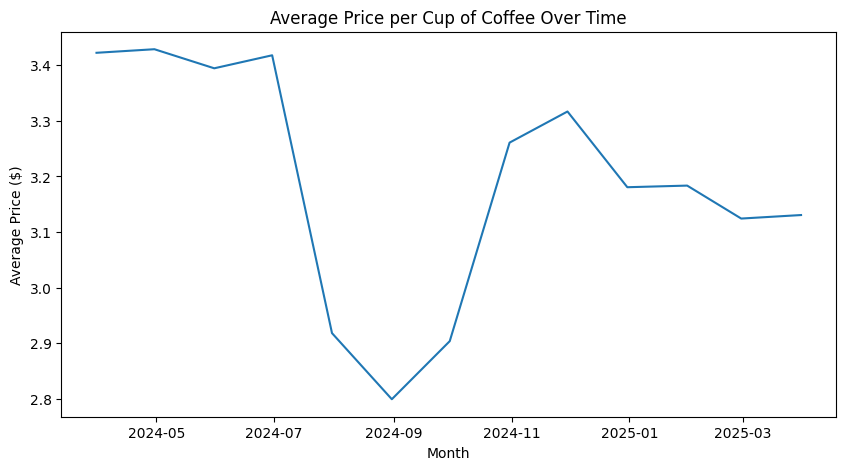

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
df = pd.read_csv('coffee_sales.csv')

# Convert the 'Date' column to datetime format for easier analysis
df['date'] = pd.to_datetime(df['date'])

# # Set the start date range we are interested in, say January 2022 and onward
# start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')

# # Filter the dataframe to only include dates within our desired range
# df = df[(df['date'] > start_date) & (df['date'].dt.date <= start_date.replace(year=start_date.year+1))].reset_index(drop=True)


# # Set the date range we are interested in, say January 2022 and onward
# end_date = datetime.strptime('2022-01-01', '%Y-%m-%d')

# Calculate the best time for coffee sales
best_time= df.groupby([df['date'].dt.hour]).size().idxmax()
print(f"The best time to sell coffee is during {best_time}.")

# Let's calculate some overall statistics
print("Number of unique coffee names:", df['coffee_name'].nunique())
print(f"Best selling coffee: {df['coffee_name'].value_counts().index[0]}")
print("Average price per cup of coffee:", round(df['price'].mean(), 2))

# Reset the index of your dataframe for easier analysis
df.reset_index(drop=True, inplace=True)

# View the first few rows of our dataset
print(df.head())

# Plot the average price over time.
monthly_avg_price = df.resample('M', on='date')['price'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg_price.index, monthly_avg_price.values)
plt.title("Average Price per Cup of Coffee Over Time")
plt.xlabel("Month")
plt.ylabel("Average Price ($)")
plt.show()

In [91]:
def get_feedback(original_prompt: str, model: str = "llama3") -> str:
    """Call the configured client using chat completions (works with Ollama)."""
    print(f"[project_utils] get_feedback model={model!r}")

    prompt = f"Here is some code you generated earlier:\n\n{original_prompt}\n\nPlease review the following prompt and ensure that the code you generated is correct and complete. If there are any issues or missing imports, please provide the corrected code.\n\n"

    try:
        resp = openai_client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": prompt}],
        )

        # Try common response shapes (dict-like or object with attributes)
        choices = None
        if isinstance(resp, dict):
            choices = resp.get("choices", [])
        else:
            choices = getattr(resp, "choices", None) or []

        if choices:
            choice0 = choices[0]
            # dict-style
            if isinstance(choice0, dict):
                message = choice0.get("message", {})
                content = message.get("content") if isinstance(message, dict) else None
                if isinstance(content, str):
                    return content
            else:
                # object-style
                try:
                    return choice0.message.content
                except Exception:
                    pass

        return str(resp)

    except Exception as e:
        print("[project_utils] get_response failed:", type(e).__name__, e)
        raise